In [10]:
import cv2
import os
import h5py
import glob

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
from keras.regularizers import l2
from PIL import Image



In [2]:
video_path = r'C:\\Users\\The Doctor\\Desktop\\Ankit project\\data\\train.mp4'
output_dir = r'C:\\Users\\The Doctor\\Desktop\\Ankit project\\data\\another_train'

# Make sure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Failed to open video file {video_path}")
    exit()

frame_num = 0
while True:
    ret, frame = cap.read()  # Read next frame from video
    
    if not ret:  # No more frames to read
        break
    
    # Create filename with zero-padded frame number
    filename = os.path.join(output_dir, f"frame{str(frame_num).zfill(5)}.jpg")
    
    # Save frame as JPEG file
    cv2.imwrite(filename, frame)  # Use `frame` instead of `cropped_frame`
    
    frame_num += 1

# Close video file
cap.release()

print(f"Extracted and saved {frame_num} frames.")


KeyboardInterrupt: 

In [11]:
# Define the box coordinates (left, upper, right, lower)
box = (48, 245, 275, 352)

for input_filepath in input_filepaths:
    # Open an image file
    img = Image.open(input_filepath)
    # Crop the image
    cropped_img = img.crop(box)
    
    # Create the output file path
    basename = os.path.basename(input_filepath)
    output_filepath = os.path.join(output_dir, basename)
    
    # Save the cropped image
    cropped_img.save(output_filepath)

In [7]:
image_dir = r'C:\Users\The Doctor\Desktop\Ankit project\data\another_train'
output_dir = r'C:\\Users\\The Doctor\\Desktop\\Ankit project\\data\\another_train'

input_filepaths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]



In [ ]:
def calculate_optical_flow_from_images(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, .4, 1, 12, 2, 8, 1.2, 0)
    
    # Calculate angle and magnitude
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    
        # Normalize magnitude to range 0-255
    mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Scale angle to range 0-255 and convert to uint8
    ang = ((ang * 180 / np.pi / 2) * (255/180)).astype(np.uint8)

    # Create a zeros array to use for coxxxxxxxxxxxxxxxxxxnstructing the HSV version of the flow
    hsv = np.zeros_like(img1)

    # Set the value channel of the HSV image to 255, maximum value
    hsv[..., 2] = 255

    # Set the hue channel to the angle of the flow, scaled from radians to degrees and then halved
    hsv[..., 0] = ang * 180 / np.pi / 2

    # Set the saturation channel to the magnitude of the flow, scaled by a factor of 15 and converted to an integer
    hsv[..., 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

def process_images(image_files):
    # Create a new HDF5 file
    h5file = h5py.File('C:/Users/The Doctor/Desktop/Ankit project/data/optical_flows.h5', 'w')

    images = []  # will now store BGR images
    for i in range(len(image_files) - 1):
        # Read in each pair of images
        img1 = cv2.imread(image_files[i])
        img2 = cv2.imread(image_files[i+1])
        
        # Calculate optical flow between the pair of images
        bgr = calculate_optical_flow_from_images(img1, img2)  # Receive BGR

        images.append(bgr)

        # If we've processed enough images for a batch or have reached the end of the images
        if len(images) == 10 or i == len(image_files) - 2:
            # Convert the list to a numpy array and store it in HDF5 file
            batch_num = str(i // 10).zfill(5)  # padded with zeros
            h5file.create_dataset(f'batch_{batch_num}_bgr', data=np.array(images))  # now stores BGR images

            # Reset the list for the next batch
            images = []  # reset for the next batch

    # Close the file
    h5file.close()

process_images(input_filepaths)


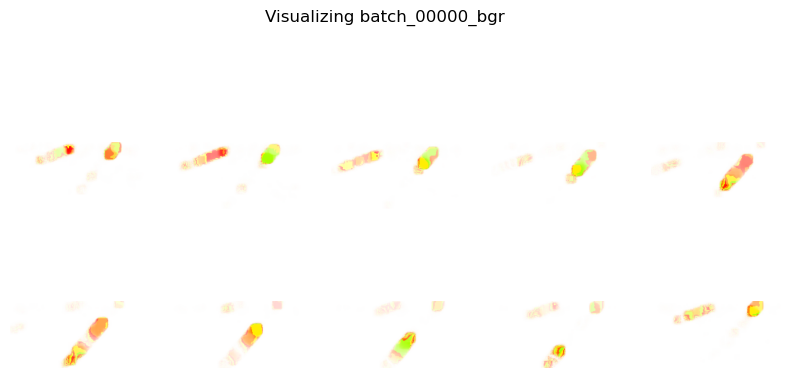

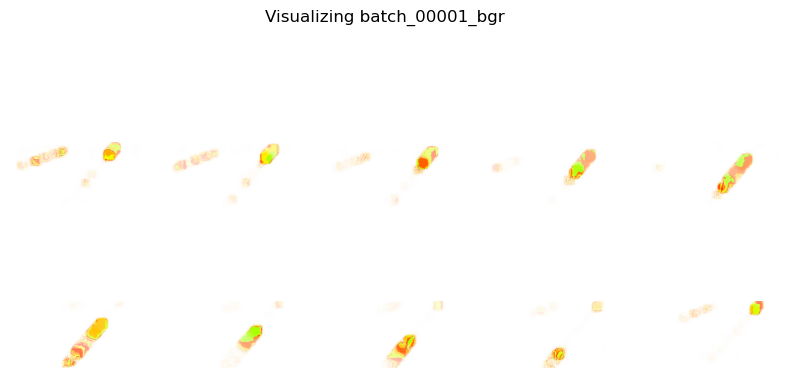

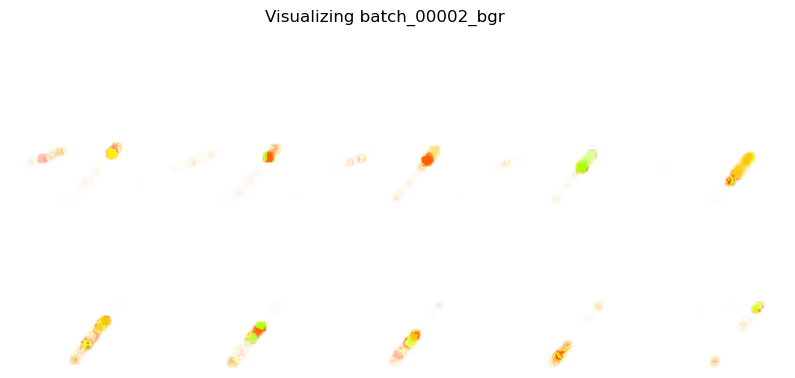

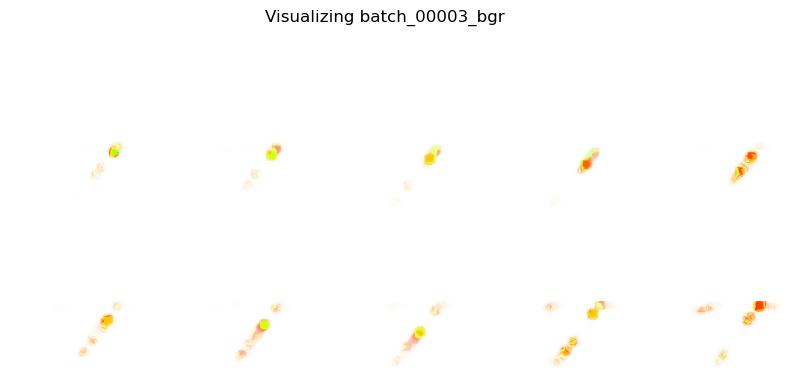

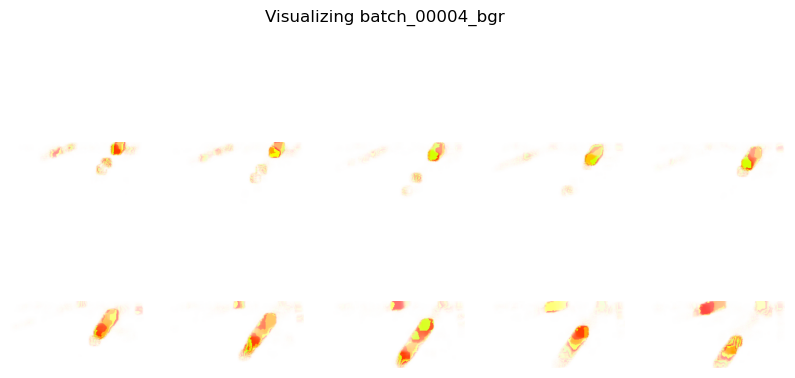

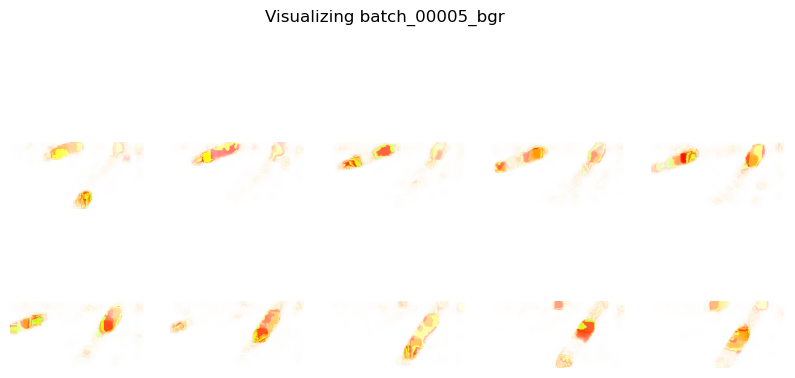

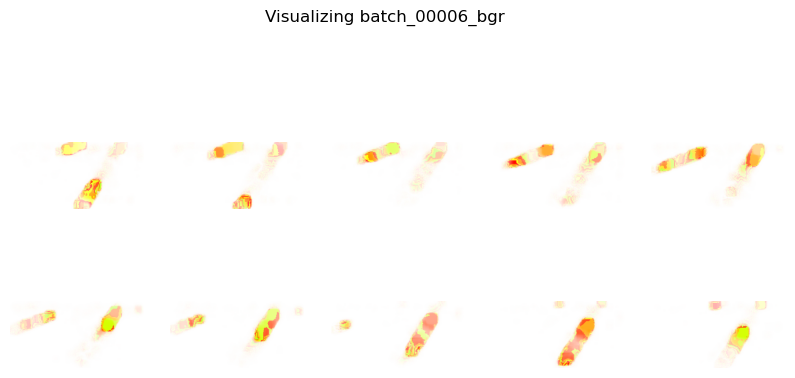

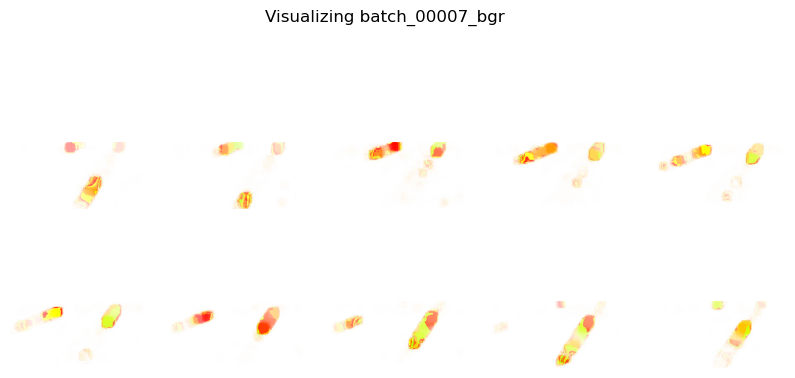

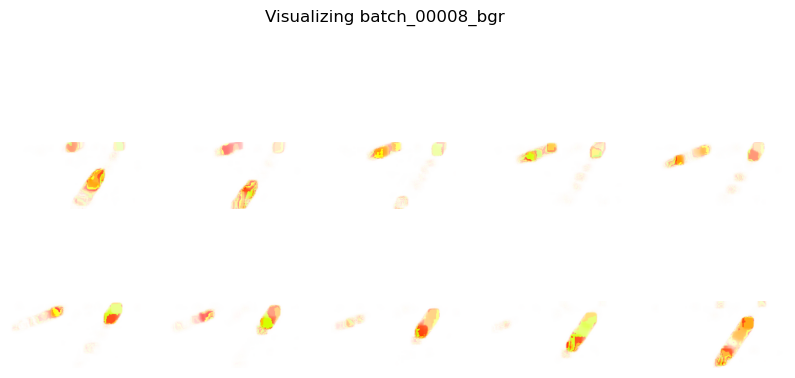

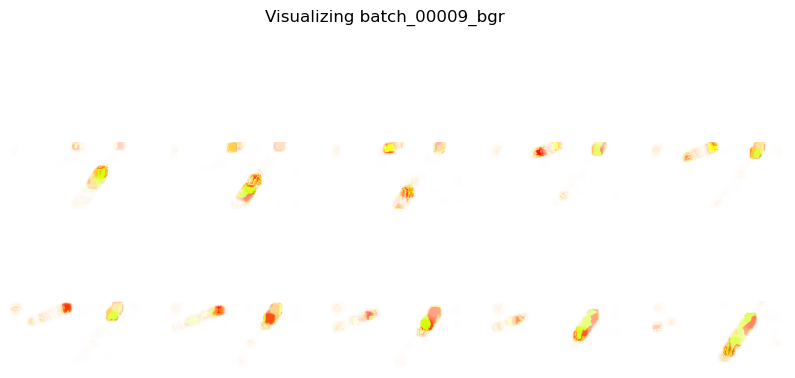

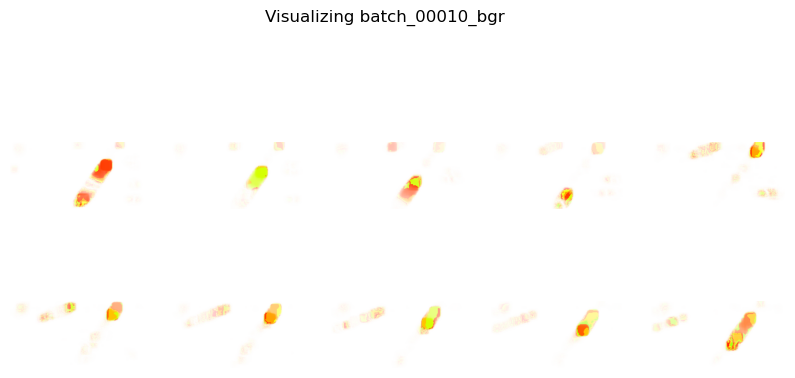

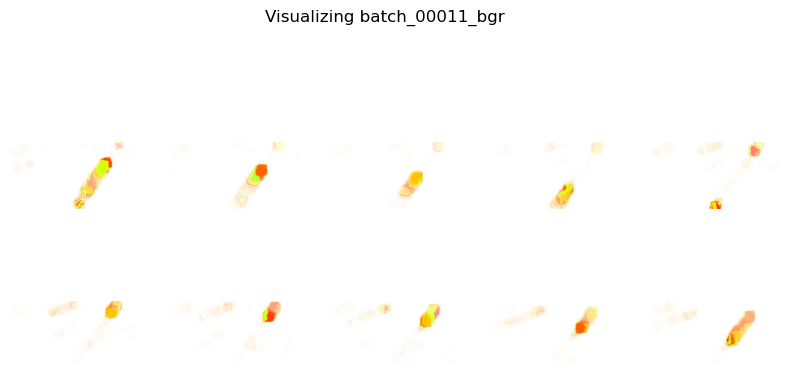

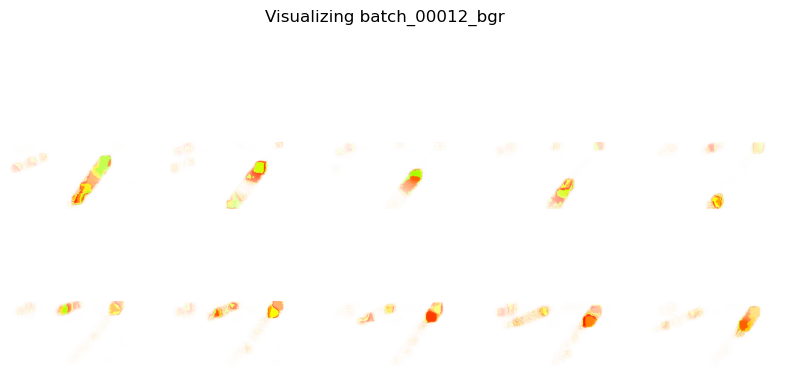

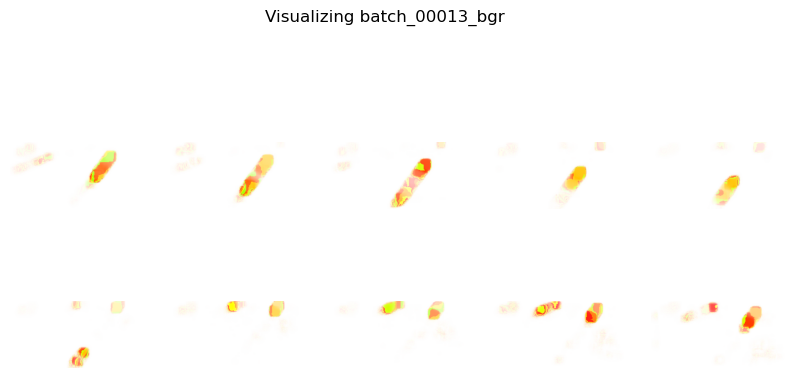

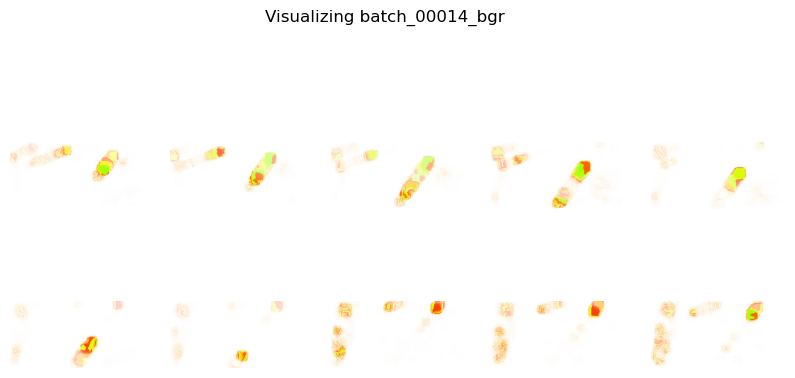

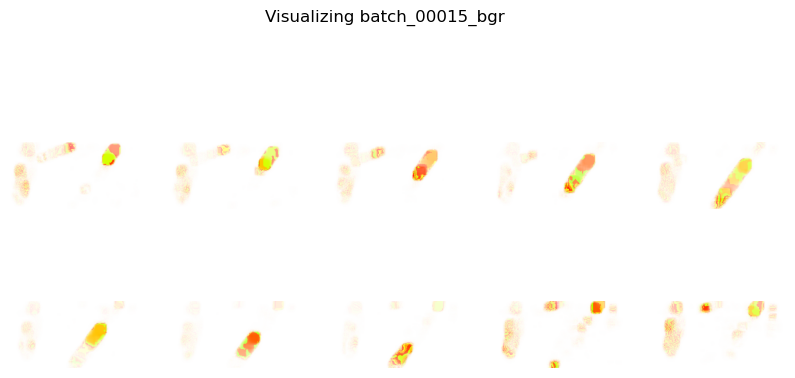

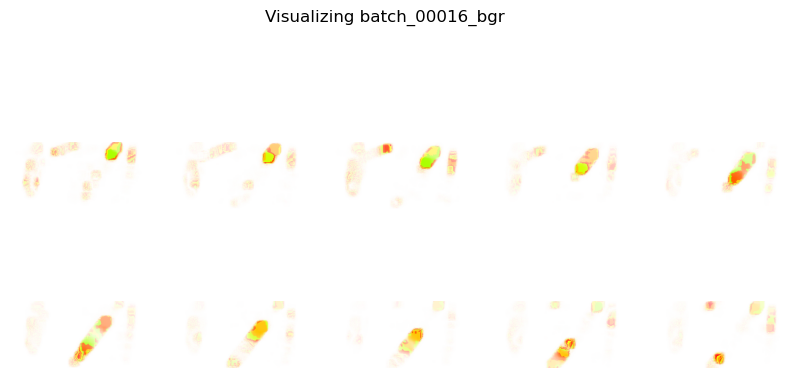

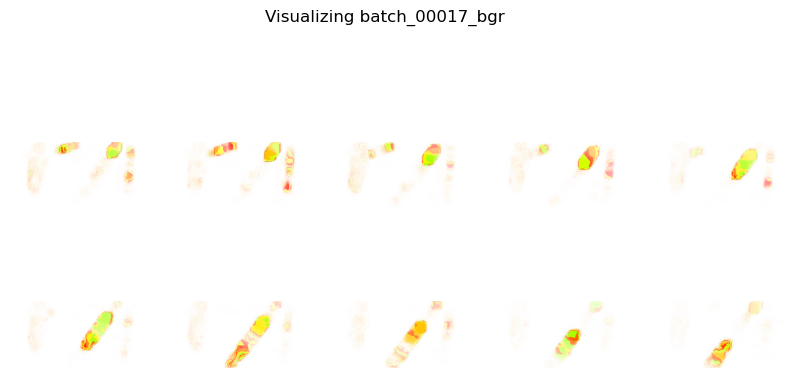

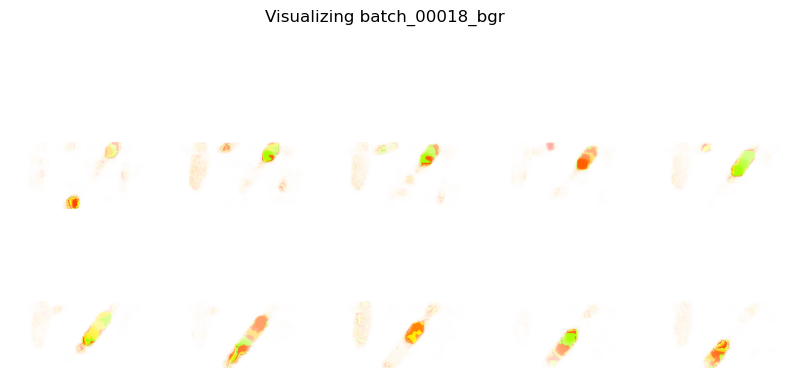

KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt

def visualize_images(h5file):
    # Loop over all datasets (batches) in the HDF5 file
    for dataset_name in h5file.keys():
        # Load the batch of images
        images = h5file[dataset_name]

        # Plot the images
        plt.figure(figsize=(10, 10))
        for i in range(len(images)):
            plt.subplot(5, 5, i+1)  # Assuming max 25 images in a batch
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert to RGB for plotting
            plt.axis('off')
            
        plt.suptitle(f'Visualizing {dataset_name}')
        plt.show()
#open the HDF5 file and call the function:
h5file = h5py.File('C:/Users/The Doctor/Desktop/Ankit project/data/optical_flows.h5', 'r')
visualize_images(h5file)
h5file.close()


In [2]:
batch_per_calc = 2
N_img_height = 107
N_img_width = 227
N_img_channels = 3
def nvidia_model():
    inputShape = (batch_per_calc, N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))

    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', kernel_regularizer=l2(.001), name = 'fc1'))

    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', kernel_regularizer=l2(.001), name = 'fc2'))

    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', kernel_regularizer=l2(.001), name = 'fc3'))

    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [3]:
class DataGenerator(Sequence):
    def __init__(self, data_file, labels, keys, batch_size=1, sequence_length=2):  
        self.data_file = data_file
        self.labels = labels
        self.keys = keys
        self.batch_size = batch_size
        self.sequence_length = sequence_length

    def __len__(self):
        return (len(self.keys) * (10 // self.sequence_length)) // self.batch_size  # Do not subtract 1, to not discard a sequence

    def __getitem__(self, index):
        key_index = index * self.batch_size // (10 // self.sequence_length)
        sequence_start = (index * self.batch_size * self.sequence_length) % 10

        batch_data = []
        batch_labels = []

        for i in range(self.batch_size):
            key = self.keys[key_index]
            frames = self.data_file['batch_' + str(key).zfill(5) + '_bgr'][()]  # Load the combined images

            sequences = []
            for j in range(self.sequence_length):
                frame_index = (sequence_start + j) % len(frames)
                sequences.append(frames[frame_index])

            batch_data.append(sequences)
            # Take only the last label for each sequence
            batch_labels.append(self.labels[frame_index + key*10])

            if sequence_start + self.sequence_length > 9:  # Update the condition to prevent missing the last sequence
                sequence_start = 0
                key_index += 1
            else:
                sequence_start += self.sequence_length
        
        batch_data = np.array(batch_data)
        batch_labels = np.array(batch_labels)
        
        # Rest of your code

        return batch_data, batch_labels

# Define the batch_size
batch_size = 1

# Load the labels from the text file
# Open the HDF5 file
data_file = h5py.File('C:/Users/The Doctor/Desktop/Ankit project/data/optical_flows.h5', 'r')
labels = np.loadtxt('C:/Users/The Doctor/Desktop/Ankit project/data/train.txt')

keys = []
for key in list(data_file.keys()):
    split_key = key.split('_')
    if len(split_key) > 1:
        keys.append(int(split_key[1]))
    else:
        print(f"Unexpected key format: {key}")
keys.sort()

# Split the keys into training, validation, and test sets, without shuffling
split_point1 = int(len(keys) * 0.80)
split_point2 = int(len(keys) * 0.90)
train_keys, val_keys, test_keys = keys[:split_point1], keys[split_point1:split_point2], keys[split_point2:]

# Initialize generators
train_gen = DataGenerator(data_file, labels, train_keys, batch_size=batch_size)
val_gen = DataGenerator(data_file, labels, val_keys, batch_size=batch_size)
test_gen = DataGenerator(data_file, labels, test_keys, batch_size=batch_size)  # Generator for the test set


In [ ]:
# Initialize your data generator
data_gen = DataGenerator(data_file, labels, train_keys, batch_size=2)  # Adjust as necessary

# Use the generator's __getitem__ method to get a batch
batch_index = 0  # Choose an index
batch_data, batch_labels = data_gen.__getitem__(batch_index)

# Now batch_data and batch_labels contain the data and labels for a single batch. You can inspect these variables to see what data is being fed into your model.
print("Batch data shape: ", batch_data.shape)
print("Batch labels shape: ", batch_labels.shape)

# If you want to see the actual data/labels
print("Batch data: ", batch_data)
print("Batch labels: ", batch_labels)


In [4]:
from keras.callbacks import LearningRateScheduler

# Define a learning rate schedule. For example, we can decrease the learning rate over epochs.
def scheduler(epoch, learning_rate):
      if epoch < 10:
        return learning_rate
      else:
        return learning_rate * tf.math.exp(-0.1)

# Create a callback for the learning rate scheduler
lr_scheduler_callback = LearningRateScheduler(scheduler)

filepath = 'C:/Users/The Doctor/Desktop/Ankit project/data/model-weights-Vtest3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              min_delta = 0.01,
                              mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

callbacks_list = [modelCheckpoint, earlyStopping]


In [5]:
#Train your model using the generators
model = nvidia_model()

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    validation_steps=len(val_gen),
                    epochs=25, 
                    steps_per_epoch=len(train_gen), 
                    callbacks=callbacks_list, 
                    verbose=1)


print(model.summary())

Epoch 1/25
8160/8160 [==============================] - ETA: 0s - loss: 30.3983
Epoch 1: val_loss improved from inf to 16.21676, saving model to C:/Users/The Doctor/Desktop/Ankit project/data\model-weights-Vtest3.h5
8160/8160 [==============================] - 247s 30ms/step - loss: 30.3983 - val_loss: 16.2168
Epoch 2/25
8159/8160 [============================>.] - ETA: 0s - loss: 14.6305
Epoch 2: val_loss did not improve from 16.21676
8160/8160 [==============================] - 255s 31ms/step - loss: 14.6291 - val_loss: 19.3000
Epoch 3/25
8160/8160 [==============================] - ETA: 0s - loss: 10.4224
Epoch 3: val_loss improved from 16.21676 to 15.48185, saving model to C:/Users/The Doctor/Desktop/Ankit project/data\model-weights-Vtest3.h5
8160/8160 [==============================] - 273s 33ms/step - loss: 10.4224 - val_loss: 15.4818
Epoch 4/25
8160/8160 [==============================] - ETA: 0s - loss: 8.2707
Epoch 4: val_loss improved from 15.48185 to 12.55489, saving model t

                                                                 
 fc2 (Dense)                 (None, 50)                5050      
                                                                 
 elu_6 (ELU)                 (None, 50)                0         
                                                                 
 fc3 (Dense)                 (None, 10)                510       
                                                                 
 elu_7 (ELU)                 (None, 10)                0         
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 2,018,619
Trainable params: 2,018,619
Non-trainable params: 0
_________________________________________________________________
None


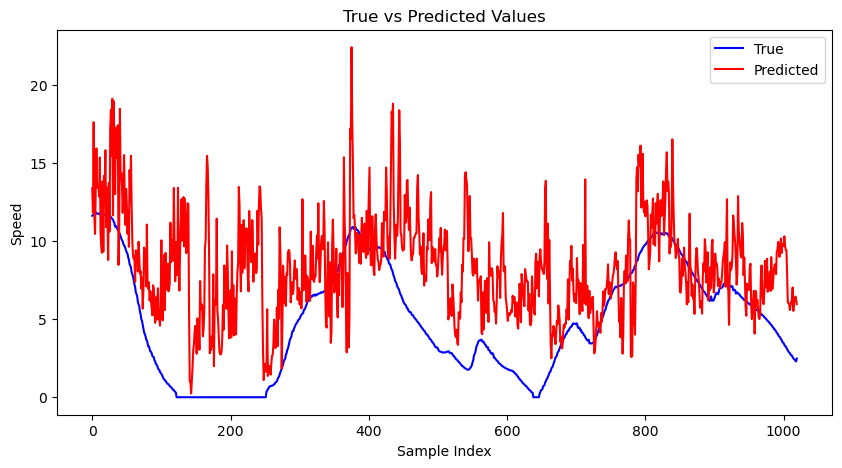

In [11]:
def extract_labels(generator):
    labels = []
    for _, batch_labels in generator:
        labels.extend(batch_labels.flatten())  # Flattens and appends to the list
    return np.array(labels)

# Extract the true labels
test_labels = extract_labels(test_gen)

# Smooth the true label
# Now plot the true labels against the predicted ones
plt.figure(figsize=(10,5))
plt.plot(test_labels, color='blue', label='True')
plt.plot(predicted_speeds, color='red', label='Predicted')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Speed')
plt.legend()
plt.show()


In [2]:
'''

TO DO:

Fix the models ability to read if we're going zero, my gut tells me that the model is reading other cars moving
while we're stopped
'''